### Exercise: energy consumption in building vs outside air temperature
The data provided in `buildingoat.csv` uses a dataset to model the Power of a building using the Outdoor Air Temperature (OAT) as an explanatory variable.  The **power** (Dutch: Vermogen), expressed in Watt (W),  of a building is a measure for the instantaneous energy comsumption.  Compare it to a light bulb of 10 W: if it is used for one hour it consumes 10 Wh (or 0.01 kWh) of electricity. On your electrity bill you are charged per kWh. Similarly, the power of a building in this exercise determines the energy consumption for heating.  A power of 160 kW (at a given outside temperature and a required inside temperature, which may vary during the day and week) means the building "looses" 160 kWh of heat energy per hour, which has to be provided by the heating installation to ensure a constant inside temperature.

Setup Python

In [1]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

Import buildingoat.csv from https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/buildingoat.csv. Show the first 5 records

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/buildingoat.csv')
data.head()

,Timestamp,OAT (F),Power (kW)
0,1/1/2010 1:15,51,165.1
1,1/1/2010 1:30,51,151.6
2,1/1/2010 1:45,51,146.9
3,1/1/2010 2:00,51,153.7
4,1/1/2010 2:15,51,153.8


Explore the datatypes and non-null values per column

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34940 entries, 0 to 34939
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Timestamp   34940 non-null  object 
 1   OAT (F)     34940 non-null  int64  
 2   Power (kW)  34940 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 819.0+ KB


The temperature is expressed in degrees Fahrenheit (°F), which is used in the US. We can convert Fahrenheit to Celcius using the formula 

$°C = \frac{°F - 32}{1.8}$

Convert all values °F to °C. 

In [5]:
def Fahrenheit2Celcius(f):
    return (f - 32)/1.8

data['OAT (C)'] = (data['OAT (F)']).apply(Fahrenheit2Celcius)
print(data.head(10))
data.drop(['OAT (F)'],axis=1,inplace=True)

       Timestamp  OAT (F)  Power (kW)    OAT (C)
0  1/1/2010 1:15       51       165.1  10.555556
1  1/1/2010 1:30       51       151.6  10.555556
2  1/1/2010 1:45       51       146.9  10.555556
3  1/1/2010 2:00       51       153.7  10.555556
4  1/1/2010 2:15       51       153.8  10.555556
5  1/1/2010 2:30       51       159.0  10.555556
6  1/1/2010 2:45       51       157.7  10.555556
7  1/1/2010 3:00       51       163.2  10.555556
8  1/1/2010 3:15       50       151.7  10.000000
9  1/1/2010 3:30       50       148.7  10.000000


Convert the type of Timestamp from 'object' to 'datetime'. This will change the format of Timestamp

In [141]:

data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%m/%d/%Y %H:%M')
data.head()

,Timestamp,Power (kW),OAT (C)
0,2010-01-01 01:15:00,165.1,10.555556
1,2010-01-01 01:30:00,151.6,10.555556
2,2010-01-01 01:45:00,146.9,10.555556
3,2010-01-01 02:00:00,153.7,10.555556
4,2010-01-01 02:15:00,153.8,10.555556


Give the dimensions of the dataset

In [143]:

data.shape

(34940, 3)

Give the statistics of the dataset

In [6]:

data.describe()

,Power (kW),OAT (C)
count,34940.000000,34940.000000
mean,261.644659,14.769828
std,65.673392,4.855195
min,0.000000,0.555556
25%,194.600000,11.666667
50%,276.700000,14.444444
75%,312.300000,17.777778
max,457.900000,37.777778


You can see that the mean value of Power (kW) is 261.644659 and the standard deviation 65.673392.  
Assign both values to a variable.  

In [7]:
meanPower = data['Power (kW)'].mean()
stdPower = data['Power (kW)'].std()

print(meanPower)
print(stdPower)

261.64465941614196
65.67339168302733


Let's do some data cleaning by removing outliers according to the 68-95-99.7 - rule: drop all values that are more than 3 standard deviations from the mean
This is a popular way of removing outliers from the dataset, which are often bad registrations. 

In [8]:

data = data[(data['Power (kW)'] >= (meanPower - 3 * stdPower)) & (data['Power (kW)'] <= (meanPower + 3 * stdPower))]
data

,Timestamp,Power (kW),OAT (C)
0,1/1/2010 1:15,165.1,10.555556
1,1/1/2010 1:30,151.6,10.555556
2,1/1/2010 1:45,146.9,10.555556
3,1/1/2010 2:00,153.7,10.555556
4,1/1/2010 2:15,153.8,10.555556
...,...,...,...
34935,12/30/2010 23:00,285.8,8.333333
34936,12/30/2010 23:15,206.6,6.666667
34937,12/30/2010 23:30,205.9,6.666667
34938,12/30/2010 23:45,189.4,6.666667


You can guess there is a dependancy between the power consumption and the outside temperature.  
Plot the Power (kW) versus the OAT (C). 

<AxesSubplot:xlabel='OAT (C)', ylabel='Power (kW)'>

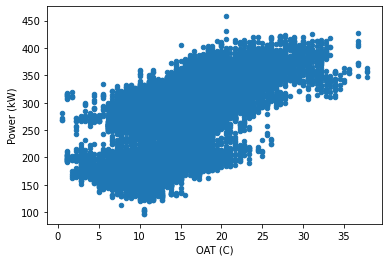

In [9]:

data.plot(kind='scatter',x='OAT (C)', y='Power (kW)')

The Power is probably also highly dependent on the month of the year, the day of the week and the time of the day.  
We will use this information to incorporate it into our regression model.  
Add extra columns for the month, day of the week and hour of the day, all as integer values. 

In [11]:

data['Month'] = pd.DatetimeIndex(data['Timestamp']).month

In [151]:
# Add an extra column Day. The day has the integer value of the day (e.g. not 01, but 1)
data['Day'] = data['Timestamp'].str[8:10].astype(int)
data.head()

,Timestamp,Power (kW),OAT (C),Month,Day
0,2010-01-01 01:15:00,165.1,10.555556,1,1
1,2010-01-01 01:30:00,151.6,10.555556,1,1
2,2010-01-01 01:45:00,146.9,10.555556,1,1
3,2010-01-01 02:00:00,153.7,10.555556,1,1
4,2010-01-01 02:15:00,153.8,10.555556,1,1


In [152]:
# Add an extra column Hour. The Hour has the integer value of the hour (e.g. not 01, but 1)
data['Hour'] = data['Timestamp'].str[11:13].astype(int)
data.head()

,Timestamp,Power (kW),OAT (C),Month,Day,Hour
0,2010-01-01 01:15:00,165.1,10.555556,1,1,1
1,2010-01-01 01:30:00,151.6,10.555556,1,1,1
2,2010-01-01 01:45:00,146.9,10.555556,1,1,1
3,2010-01-01 02:00:00,153.7,10.555556,1,1,2
4,2010-01-01 02:15:00,153.8,10.555556,1,1,2


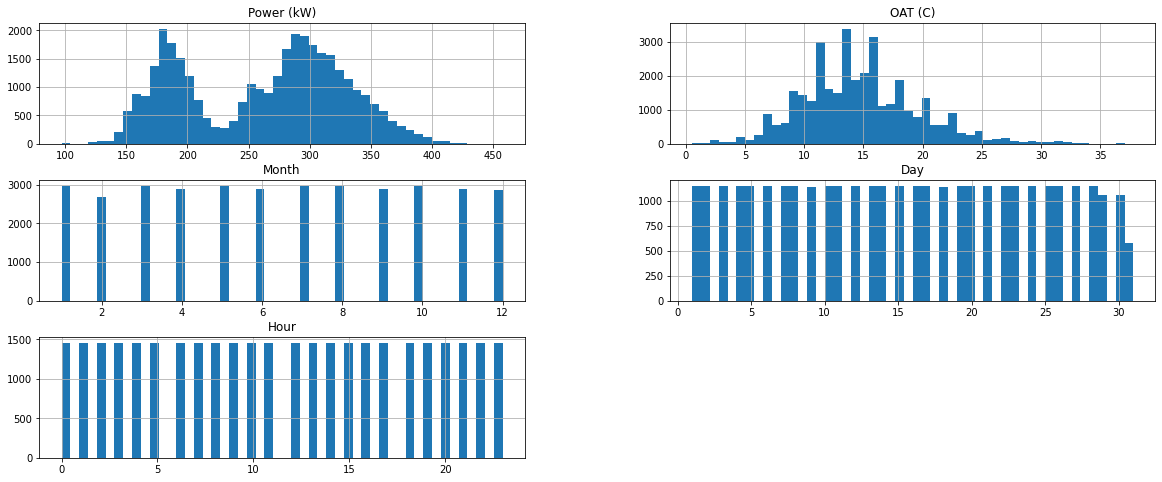

In [153]:
# plot the histogram of the numerical attribute
data.hist(bins=50, figsize=(20,8))
plt.show()


In [154]:
# Select the data of 1 specific day (e.g. 2010-03-04)
day = data[data['Timestamp'].str[0:10] == '2010-03-04']
day.head(20)

,Timestamp,Power (kW),OAT (C),Month,Day,Hour
5947,2010-03-04 00:00:00,164.2,7.222222,3,4,0
5948,2010-03-04 00:15:00,164.2,6.666667,3,4,0
5949,2010-03-04 00:30:00,160.7,6.666667,3,4,0
5950,2010-03-04 00:45:00,174.0,6.666667,3,4,0
5951,2010-03-04 01:00:00,186.2,6.666667,3,4,1
5952,2010-03-04 01:15:00,179.5,7.222222,3,4,1
5953,2010-03-04 01:30:00,168.2,7.222222,3,4,1
5954,2010-03-04 01:45:00,167.0,7.222222,3,4,1
5955,2010-03-04 02:00:00,177.5,7.222222,3,4,2
5956,2010-03-04 02:15:00,181.8,7.777778,3,4,2


Text(0, 0.5, 'OAT')

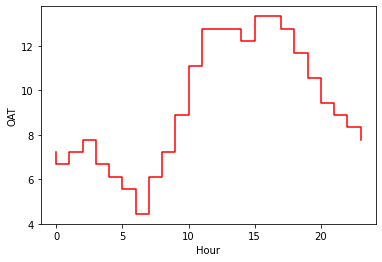

In [155]:
# Plot for that day the OAT (C) versus the Hour of day
plt.plot(day['Hour'], day['OAT (C)'], color='red')
plt.xlabel('Hour')
plt.ylabel('OAT')

Text(0, 0.5, 'Power')

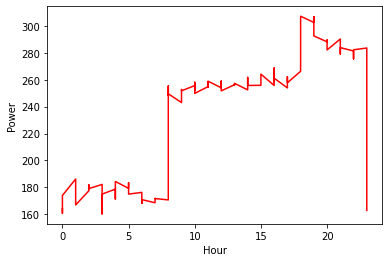

In [156]:
# Plot the Power (kW) versus the Hour of day
# This clearly illustrates people require less heating at night. 
plt.plot(day['Hour'], day['Power (kW)'], color='red')
plt.xlabel('Hour')
plt.ylabel('Power')

In [134]:
# altough month, day and hour are numeric, they are in fact categorical attributes, 
# so we apply one hot encoding

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
data_cat = data[['Month','Day','Hour']]
data_cat_1hot = cat_encoder.fit_transform(data_cat)
data_cat_1hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [136]:
X = pd.concat([data[['OAT (C)']],data_cat_1hot],axis=1)
X

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [108]:
# Use RandomForestRegressor to predict the Power (kW)
# find the optimal number of trees based on MAE
# use cross validation with 10 folds

In [109]:
# Put aside a randomized test set. 
# Since we don't have a skew dataset stratified sampling is nog really necessary
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [110]:
print(len(train_set))
print(len(test_set))

27930
6983


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [21]:
from sklearn.model_selection import train_test_split
X = data.drop(['Timestamp','Power (kW)'],axis=1)
y = data['Power (kW)']

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

X_remainder, X_test, y_remainder, y_test = train_test_split(X,y,test_size=0.30)

best_MAE = 1000
best_trees = 0

for trees in range(50,500,50):
    X_train, X_validation, y_train, y_validation = train_test_split(X_remainder,y_remainder,test_size=0.30)
    model = RandomForestRegressor(n_estimators=trees)

    model.fit(X_train, y_train)    
    y_validation2 = model.predict(X_validation)
    MAE = mean_absolute_error(y_validation, y_validation2)
    if MAE < best_MAE:
        best_MAE = MAE
        best_trees = trees
        best_validation = model.predict(X_test)
        
print('Optimal number of trees = % s' %(best_trees))
print('MAE on validation set = % 3.2f' % (best_MAE)) 
MAEOnTestSet = mean_absolute_error(y_test, best_validation)
print('MAE on test set = % 3.2f' % (MAEOnTestSet))
r2 = r2_score(y_test,best_validation)
print('R square: ' + str(r2))   

Optimal number of trees = 350
MAE on validation set =  10.11
MAE on test set =  10.20
R square: 0.9245715170611813
